# Automatyczna klasyfikacja stanu opon samochodowych przy użyciu technik głębokiego uczenia

## Struktura dokumentu

## Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Analiza zbioru danych

### Definicja styli


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style directly using seaborn
sns.set_theme(style='darkgrid')  # Base style

# Define custom modifications
plt.rcParams['axes.titlesize'] = 14  # Title size
plt.rcParams['axes.labelsize'] = 12  # Axis label size
plt.rcParams['xtick.labelsize'] = 10  # X tick label size
plt.rcParams['ytick.labelsize'] = 10  # Y tick label size
plt.rcParams['axes.edgecolor'] = 'gray'  # Axis edge color
plt.rcParams['axes.facecolor'] = 'white'  # Background color

 W ramach projektu skorzystano z dwóch ogólnodostępnych zbiorów danych, które są jedynymi, do których udało się uzyskać dostęp w kontekście tego badania.

1. **Kaggle Tyre Quality Classification** - https://www.kaggle.com/datasets/warcoder/tyre-quality-classification/code
2. **Mendeley Data Tyre Dataset** - https://data.mendeley.com/datasets/32b5vfj6tc/


In [6]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

path_to_kaggle_data = '/content/drive/My Drive/Magisterka/Data/Kaggle Dataset/'
path_to_mendeley_data = '/content/drive/My Drive/Magisterka/Data/TyreDataset_Mendeley/'
output_folder = '/content/drive/My Drive/Magisterka/ResearchData/'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

### Podstawowe informacje o zbiorach danych

In [ ]:
import os
import hashlib
from PIL import Image
from pathlib import Path
import random
import matplotlib.pyplot as plt

In [ ]:
import os
from PIL import Image

def analyze_dataset(path, categories=['good', 'defective']):
    """Analyzes dataset for given categories to gather various image properties."""
    data_info = {
        'total_images': 0,
        'square_images': 0,
        'grayscale_images': 0,
        'unique_sizes': set(),
        'non_square_sizes': set(),  # Set to hold non-square image sizes
        'category_counts': {category: 0 for category in categories},
        'defective_count': 0,
        'total_width': 0,
        'total_height': 0,
        'file_sizes': [],
    }

    for category in categories:
        category_path = os.path.join(path, category)
        images = os.listdir(category_path)
        data_info['category_counts'][category] = len(images)
        data_info['total_images'] += len(images)

        if category == 'defective':
            data_info['defective_count'] += len(images)

        for image_name in images:
            image_path = os.path.join(category_path, image_name)
            try:
                with Image.open(image_path) as img:
                    size = img.size
                    data_info['unique_sizes'].add(size)
                    if size[0] == size[1]:
                        data_info['square_images'] += 1
                    else:
                        data_info['non_square_sizes'].add(size)

                    if img.mode == 'L':
                        data_info['grayscale_images'] += 1

                    data_info['total_width'] += size[0]
                    data_info['total_height'] += size[1]

                    aspect_ratio = round(size[0] / size[1], 2)
                    if 'aspect_ratios' not in data_info:
                        data_info['aspect_ratios'] = {}
                    if aspect_ratio in data_info['aspect_ratios']:
                        data_info['aspect_ratios'][aspect_ratio] += 1
                    else:
                        data_info['aspect_ratios'][aspect_ratio] = 1

                    file_size_kb = os.path.getsize(image_path) / 1024  # KB
                    data_info['file_sizes'].append(file_size_kb)
            except Exception as e:
                print(f"Error processing image {image_path}: {e}")

    if data_info['total_images'] > 0:
        data_info['defective_percentage'] = (data_info['defective_count'] / data_info['total_images']) * 100
    else:
        data_info['defective_percentage'] = 0

    if data_info['total_images'] > 0:
        data_info['average_width'] = data_info['total_width'] / data_info['total_images']
        data_info['average_height'] = data_info['total_height'] / data_info['total_images']
    else:
        data_info['average_width'] = 0
        data_info['average_height'] = 0

    if data_info['file_sizes']:
        data_info['average_file_size'] = sum(data_info['file_sizes']) / len(data_info['file_sizes'])
    else:
        data_info['average_file_size'] = 0

    return data_info

def display_dataset_info(data_info, dataset_name):
    """Displays collected dataset information."""
    print(f"Informacje o zbiorze danych {dataset_name}:")
    print(f"  Łączna liczba obrazów: {data_info['total_images']}")
    for category, count in data_info['category_counts'].items():
        print(f"  Liczba obrazów w kategorii '{category}': {count}")
    print(f"  Liczba obrazów kwadratowych: {data_info['square_images']}")
    print(f"  Liczba obrazów w skali szarości: {data_info['grayscale_images']}")
    print(f"  Unikalne rozmiary obrazów: {data_info['unique_sizes']}")
    print(f"  Rozmiary obrazów niekwadratowych: {data_info['non_square_sizes']}")
    print(f"  Procent uszkodzonych obrazów: {data_info.get('defective_percentage', 0):.2f}%")
    print(f"  Średnia szerokość obrazów: {data_info.get('average_width', 0):.2f} pikseli")
    print(f"  Średnia wysokość obrazów: {data_info.get('average_height', 0):.2f} pikseli")
    print(f"  Rozkład proporcji (Aspect Ratios): {data_info.get('aspect_ratios', {})}")
    print(f"  Średni rozmiar pliku: {data_info.get('average_file_size', 0):.2f} KB")


In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import matplotlib.patches as patches

def display_random_images(
    dataset_path,
    num_images=12,
    nrows=3,
    ncols=4,
    target_size=(300, 300),
    padding_color=(255, 255, 255),
    border_color='black',
    border_width=2,
    label_bg_color=(0, 0, 0, 0.6),
    label_text_color='white',
    label_fontsize=16
):
    """
    Displays random images with labels overlaid on them with a full-width semi-transparent background
    at the bottom of each image. All images are scaled to a uniform size while maintaining aspect ratios
    without cropping. Additionally, a border is added around each image, and padding fills any remaining
    space.

    :param dataset_path: Path to the dataset folder containing 'good' and 'defective' subdirectories.
    :param num_images: Number of images to display. Default is 12.
    :param nrows: Number of rows in the subplot grid. Default is 3.
    :param ncols: Number of columns in the subplot grid. Default is 4.
    :param target_size: Tuple (width, height) in pixels to scale images. Default is (300, 300).
    :param padding_color: Background color for padding as a tuple (R, G, B). Default is white (255, 255, 255).
    :param border_color: Color of the border around each image. Default is 'black'.
    :param border_width: Width of the border in pixels. Default is 2.
    :param label_bg_color: Background color for the label in RGBA format. Default is semi-transparent black (0, 0, 0, 0.6).
    :param label_text_color: Color of the label text. Default is 'white'.
    :param label_fontsize: Font size of the label text. Default is 16.
    """
    # Define the categories and their corresponding labels
    categories = {
        'good': 'Sprawna',
        'defective': 'Wadliwa'
    }

    # Prepare paths for each category
    category_paths = {category: os.path.join(dataset_path, category) for category in categories}

    # Collect all image file paths from each category
    all_images = []
    for category, path in category_paths.items():
        if not os.path.isdir(path):
            print(f"Warning: Directory '{path}' does not exist. Skipping this category.")
            continue
        # List all files in the category directory
        category_images = [
            os.path.join(path, f) for f in os.listdir(path)
            if os.path.isfile(os.path.join(path, f))
        ]
        all_images.extend(category_images)

    if not all_images:
        print("Error: No images found in the specified dataset path.")
        return

    # Shuffle the combined list of images
    random.shuffle(all_images)

    # Select a random sample of images
    selected_images = random.sample(all_images, min(num_images, len(all_images)))

    # Set up the plot with specified number of rows and columns
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 3, nrows * 3))
    axes = axes.ravel()  # Flatten the axes array for easy iteration

    for i, image_path in enumerate(selected_images):
        try:
            # Open and convert the image to RGB
            img = Image.open(image_path).convert("RGB")

            # Scale the image while maintaining aspect ratio
            if hasattr(Image, 'Resampling'):
                resample_method = Image.Resampling.LANCZOS
            else:
                resample_method = Image.LANCZOS  # For older Pillow versions
            img.thumbnail(target_size, resample_method)

            # Create a new image with padding
            new_img = Image.new("RGB", target_size, padding_color)
            # Calculate position to paste the scaled image to center it
            paste_position = (
                (target_size[0] - img.width) // 2,
                (target_size[1] - img.height) // 2
            )
            new_img.paste(img, paste_position)

            # Determine the label based on the category
            label = "Sprawna" if 'good' in image_path.lower() else "Wadliwa"

            # Display the image
            axes[i].imshow(new_img)
            axes[i].axis('off')  # Hide axis ticks and labels

            # Add a semi-transparent rectangle as background for the label
            axes[i].add_patch(
                patches.Rectangle(
                    (0, 0), 1, 0.12,  # Position and size in axis coordinates
                    color=label_bg_color,  # Background color with transparency
                    transform=axes[i].transAxes,  # Use axis coordinates
                    zorder=1000  # Draw below the text
                )
            )

            # Add the label text on top of the semi-transparent background
            axes[i].text(
                0.5, 0.06, label,  # Position in axis coordinates
                fontsize=label_fontsize,
                color=label_text_color,
                weight='bold',
                ha='center',
                va='center',
                transform=axes[i].transAxes,  # Use axis coordinates
                zorder=1001  # Draw above the rectangle
            )

            # Add a border around the image
            axes[i].add_patch(
                patches.Rectangle(
                    (0, 0), 1, 1,  # Position and size in axis coordinates
                    linewidth=border_width,
                    edgecolor=border_color,
                    facecolor='none',  # No fill color
                    transform=axes[i].transAxes,  # Use axis coordinates
                    zorder=1002  # Draw above everything else
                )
            )

        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            axes[i].axis('off')  # Hide the subplot if image loading fails
            continue

    # Hide any unused subplots
    for j in range(len(selected_images), nrows * ncols):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
# Analyze datasets
kaggle_data_info = analyze_dataset(path_to_kaggle_data)
mendeley_data_info = analyze_dataset(path_to_mendeley_data)

# Display dataset information
display_dataset_info(kaggle_data_info, "Kaggle")
print("\n")
display_dataset_info(mendeley_data_info, "Mendeley")

Informacje o zbiorze danych Kaggle:
  Łączna liczba obrazów: 1856
  Liczba obrazów w kategorii 'good': 828
  Liczba obrazów w kategorii 'defective': 1028
  Liczba obrazów kwadratowych: 878
  Liczba obrazów w skali szarości: 1
  Unikalne rozmiary obrazów: {(2259, 2259), (428, 428), (488, 488), (2728, 2728), (520, 520), (1218, 1218), (2168, 2168), (369, 369), (580, 580), (2049, 2049), (1200, 1200), (2292, 2292), (2109, 2109), (672, 672), (1503, 1503), (1839, 1839), (1233, 1233), (494, 494), (1041, 1041), (435, 435), (646, 646), (1344, 1344), (2703, 2703), (495, 495), (1587, 1587), (2116, 2116), (2510, 2510), (528, 528), (2602, 2602), (2240, 2240), (620, 620), (831, 831), (579, 579), (469, 469), (561, 561), (4000, 3000), (1443, 1443), (2214, 2214), (915, 915), (2274, 2274), (354, 353), (1425, 1425), (686, 686), (2517, 2517), (1476, 1476), (250, 250), (838, 838), (1536, 1536), (1568, 1568), (2156, 2156), (2550, 2550), (1628, 1628), (1266, 1266), (2248, 2248), (1509, 1509), (1812, 1812), (1

#### Przykładowe zdjęcia opon w poszczególnych zbiorach

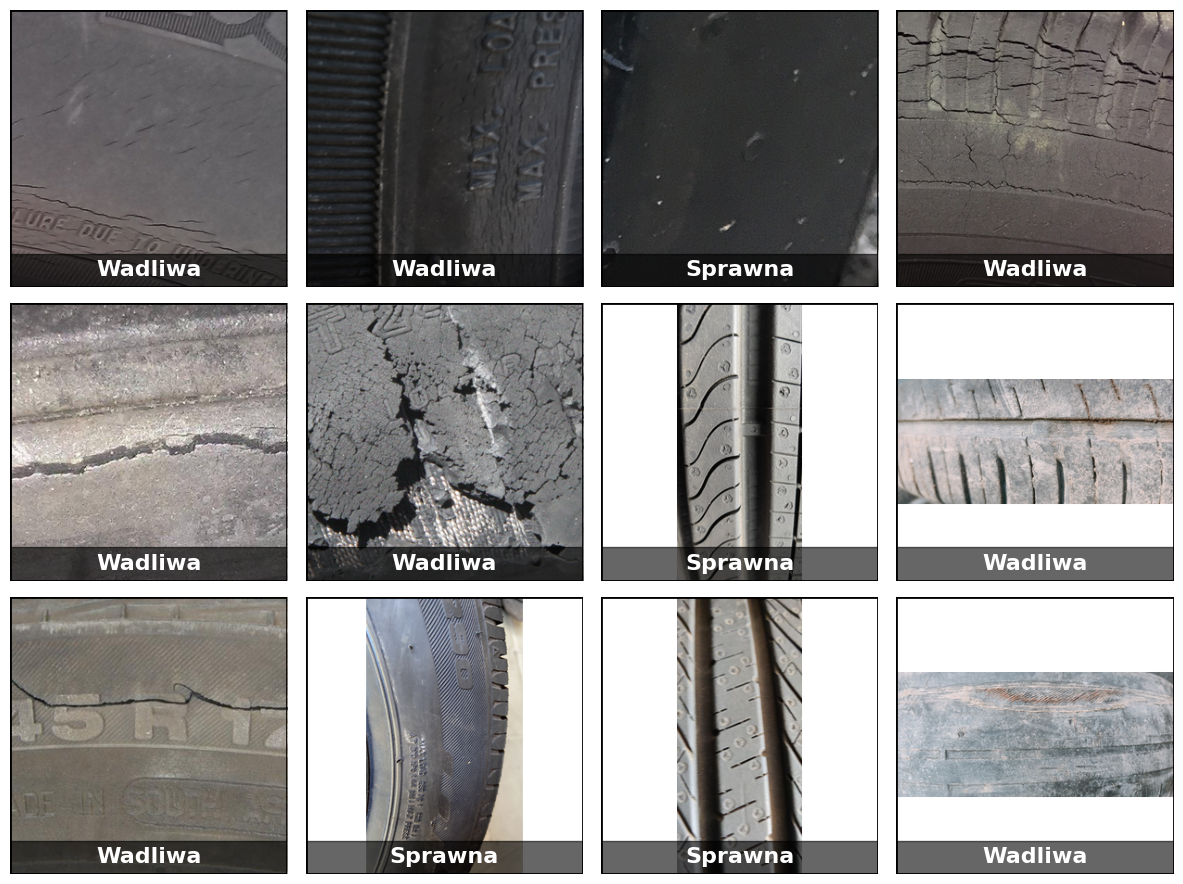

In [ ]:
display_random_images(dataset_path=path_to_kaggle_data)

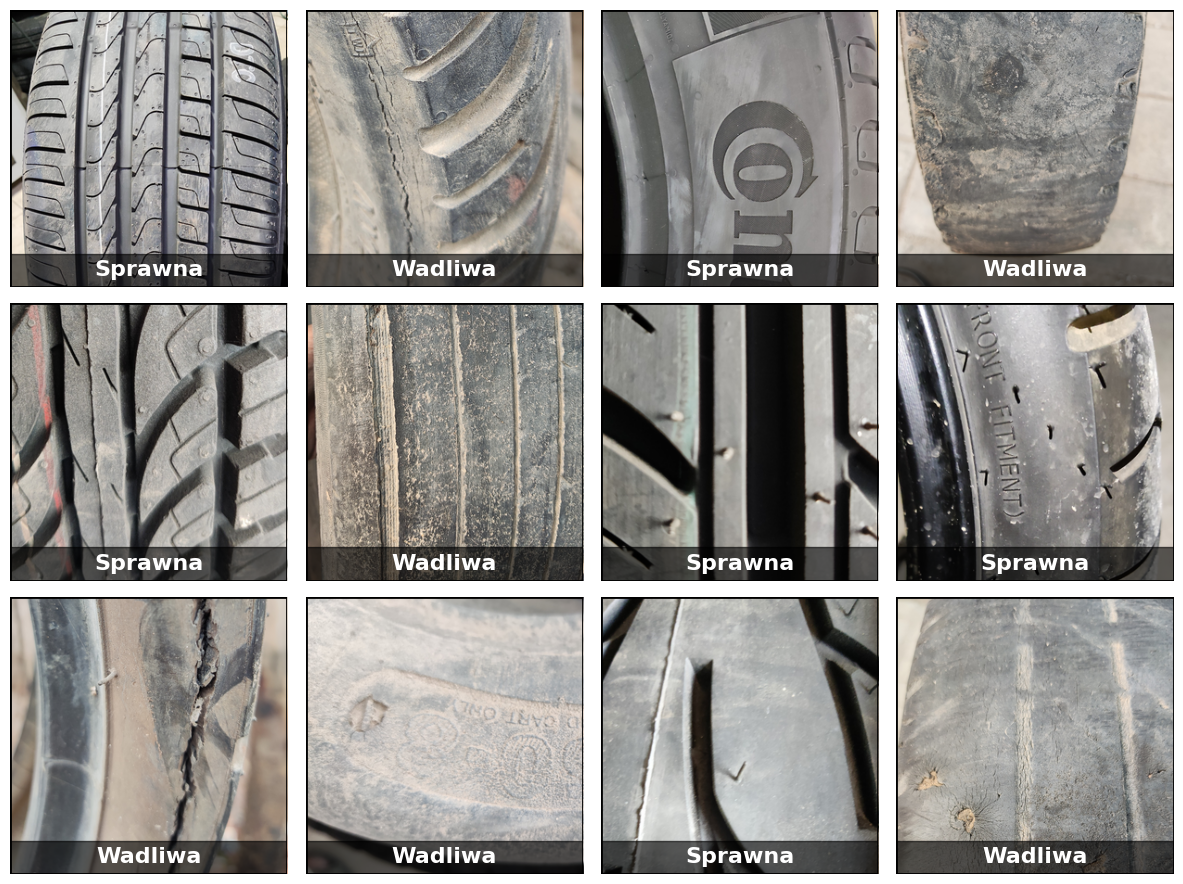

In [ ]:
display_random_images(path_to_mendeley_data)

#### Sprawdzenie czy istnieją duplikaty

In [ ]:
# Function to compute the hash of an image file
def get_image_hash(image):
    """Compute the MD5 hash for an image."""
    md5 = hashlib.md5()
    md5.update(image.tobytes())
    return md5.hexdigest()

# Function to find duplicates in directories
def find_duplicates(base_path):
    """Walk through directories to find duplicate images."""
    hashes = {}  # Dictionary to hold the hashes of the images
    file_counter = 0  # Counter to track number of files processed
    duplicate_pairs = []  # List to store pairs of duplicate images

    for dirpath, dirnames, filenames in os.walk(base_path):
        for filename in filenames:
            # Process only JPEG and PNG images
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(dirpath, filename)
                with Image.open(image_path) as image:
                    image_hash = get_image_hash(image)

                    # Add the image path to the corresponding hash entry in the dictionary
                    if image_hash in hashes:
                        hashes[image_hash].append(image_path)
                    else:
                        hashes[image_hash] = [image_path]
                file_counter += 1

    # Check for duplicates
    for image_list in hashes.values():
        if len(image_list) > 1:
            for i in range(len(image_list)):
                for j in range(i + 1, len(image_list)):
                    duplicate_pairs.append((image_list[i], image_list[j]))

    return file_counter, duplicate_pairs

In [ ]:
base_path = Path("/content/drive/My Drive/Magisterka/Data")
total_images, duplicates = find_duplicates(base_path)

print(f"Przetworzono łącznie {total_images} obrazów.")
if duplicates:
    print(f"Znaleziono {len(duplicates)} par duplikatów obrazów.")
    print("Znalezione pary duplikatów:")
    for pair in duplicates:
        print(pair)

Przetworzono łącznie 3554 obrazów.
Znaleziono 36 par duplikatów obrazów.
Znalezione pary duplikatów:
('/content/drive/My Drive/Magisterka/Data/TyreDataset_Mendeley/good/good (377).jpg', '/content/drive/My Drive/Magisterka/Data/TyreDataset_Mendeley/good/good (619).jpg')
('/content/drive/My Drive/Magisterka/Data/TyreDataset_Mendeley/good/good (108).jpg', '/content/drive/My Drive/Magisterka/Data/TyreDataset_Mendeley/good/good (467).jpg')
('/content/drive/My Drive/Magisterka/Data/TyreDataset_Mendeley/defective/Defective (618).jpg', '/content/drive/My Drive/Magisterka/Data/TyreDataset_Mendeley/defective/Defective (611).jpg')
('/content/drive/My Drive/Magisterka/Data/TyreDataset_Mendeley/defective/Defective (91).jpg', '/content/drive/My Drive/Magisterka/Data/TyreDataset_Mendeley/defective/Defective (48).jpg')
('/content/drive/My Drive/Magisterka/Data/TyreDataset_Mendeley/defective/Defective (28).jpg', '/content/drive/My Drive/Magisterka/Data/TyreDataset_Mendeley/defective/Defective (27).jpg'

### Konsolidacja Danych i Usuwanie Duplikatów

In [ ]:
import os
import shutil
from PIL import Image
from pathlib import Path

def merge_datasets(source_paths, output_folder, categories=['good', 'defective']):
    """
    Merges datasets from different sources, removes duplicates, and saves the results with source labels.

    Parameters:
    - source_paths: List of tuples [(path1, label1), (path2, label2), ...]
    - output_folder: Path to the output directory
    - categories: List of category names
    """
    # Ensure the output directory exists
    output_folder = Path(output_folder)
    output_folder.mkdir(parents=True, exist_ok=True)

    seen_images = set()  # Set to track seen (non-duplicate) images
    image_count = 0  # Counter for total images processed

    # Process each category
    for category in categories:
        category_folder = output_folder / category
        category_folder.mkdir(exist_ok=True)

        for source_path, label in source_paths:
            category_path = Path(source_path) / category
            if not category_path.exists():
                print(f"Ścieżka {category_path} nie istnieje. Pomijam.")
                continue

            for image_name in os.listdir(category_path):
                image_path = category_path / image_name
                if not image_path.is_file():
                    continue

                try:
                    with Image.open(image_path) as img:
                        img_hash = get_image_hash(img)
                except Exception as e:
                    print(f"Nie można otworzyć obrazu {image_path}: {e}")
                    continue

                if img_hash not in seen_images:
                    seen_images.add(img_hash)
                    name, ext = os.path.splitext(image_name)
                    new_image_name = f"{name}_{label}{ext}"
                    target_path = category_folder / new_image_name

                    if target_path.exists():
                        unique_id = hashlib.md5(os.urandom(16)).hexdigest()[:8]
                        new_image_name = f"{name}_{label}_{unique_id}{ext}"
                        target_path = category_folder / new_image_name

                    shutil.copy2(image_path, target_path)
                    image_count += 1

    print(f"Łączna liczba zapisanych unikalnych obrazów: {image_count}")

In [ ]:
merge_datasets(
    source_paths=[
        (path_to_kaggle_data, 'kaggle'),
        (path_to_mendeley_data, 'mendeley')
    ],
    output_folder=output_folder
)

Łączna liczba zapisanych unikalnych obrazów: 3518


### Postawowe informacje o docelowym zbiorze badawczym

In [ ]:
# Path to the research dataset folder
research_dataset_path = '/content/drive/My Drive/Magisterka/ResearchData'

In [ ]:
research_data_info = analyze_dataset(research_dataset_path)

# Display dataset information
display_dataset_info(research_data_info, "Research Dataset")

Informacje o zbiorze danych Research Dataset:
  Łączna liczba obrazów: 3518
  Liczba obrazów w kategorii 'good': 1655
  Liczba obrazów w kategorii 'defective': 1863
  Liczba obrazów kwadratowych: 2567
  Liczba obrazów w skali szarości: 1
  Unikalne rozmiary obrazów: {(2259, 2259), (428, 428), (488, 488), (2728, 2728), (520, 520), (1218, 1218), (2168, 2168), (369, 369), (580, 580), (2049, 2049), (1200, 1200), (2292, 2292), (2109, 2109), (672, 672), (1990, 1990), (1503, 1503), (1839, 1839), (2050, 2050), (1100, 1100), (1233, 1233), (494, 494), (1780, 1780), (1041, 1041), (435, 435), (646, 646), (1344, 1344), (2703, 2703), (495, 495), (1587, 1587), (2116, 2116), (2510, 2510), (2148, 2148), (528, 528), (1620, 1620), (2602, 2602), (2240, 2240), (620, 620), (831, 831), (579, 579), (469, 469), (561, 561), (2090, 2090), (4000, 3000), (1443, 1443), (2214, 2214), (915, 915), (2274, 2274), (354, 353), (1425, 1425), (686, 686), (2517, 2517), (1476, 1476), (250, 250), (838, 838), (1536, 1536), (156

W badanym zbiorze danych znajduje się 226 różnych wymiarów zdjęć, z których najczęstszym jest 2250x2250. Wśród obrazów występują zarówno formaty kwadratowe jak i prostokątne

#### Rozkład klas

In [ ]:
import plotly.express as px

def display_category_proportions(data_info):
    categories = ['Poprawne', 'Wadliwe']
    counts = [data_info['category_counts'][category] for category in ['good', 'defective']]
    total = sum(counts)
    percentages = [(count / total * 100) for count in counts]

    # Using Plotly Express to create a horizontal bar chart
    fig = px.bar(
        x=percentages,
        y=categories,
        text_auto=".1f",  # Display one decimal place
        orientation='h',  # Horizontal bar chart
        title="Rozkład jakości opon w zbiorze badawczym",
        color_discrete_sequence=["#3B3B6D"],  # Matching the dark blue color used earlier
        height=280,
        width=840
    )
    # Updating the chart layout and styles
    fig.update_xaxes(title="Procentowy udział", range=[-1, 65])
    fig.update_yaxes(title="")
    fig.update_traces(textposition='outside')
    fig.update_layout(
        font=dict(
            family="Arial",  # Consistent font family
            size=12,  # Adjust font size for readability
            color="black"  # Ensuring text is easy to read
        ),
        title_font=dict(
            family="Arial",
            size=18,
            color="black"
        ),
        plot_bgcolor="white",  # Background color for the plot area
        paper_bgcolor="white",  # Background color outside the plot area
        xaxis_showgrid=False,  # Removing grid lines for a clean look
        yaxis_showgrid=False,
        bargap=0.4,  # Adjusting the gap between bars
        title_x=0.5  # Centering the title
    )
    fig.show()

# Display the category proportions
display_category_proportions(research_data_info)

Rozkład klas w zbiorze danych to 47% dla klasy 'Dobre' i 53% dla klasy 'Wadliwe', co jest stosunkowo zrównoważone dla potrzeb klasyfikacji binarnej. Taka dystrybucja nie wymaga specjalnych technik przetwarzania wstępnego, które są potrzebne w przypadkach bardziej ekstremalnego niezrównoważenia klas. Standardowe algorytmy uczenia maszynowego powinny efektywnie radzić sobie z takim rozkładem.

#### Przykładowe zdjęcia

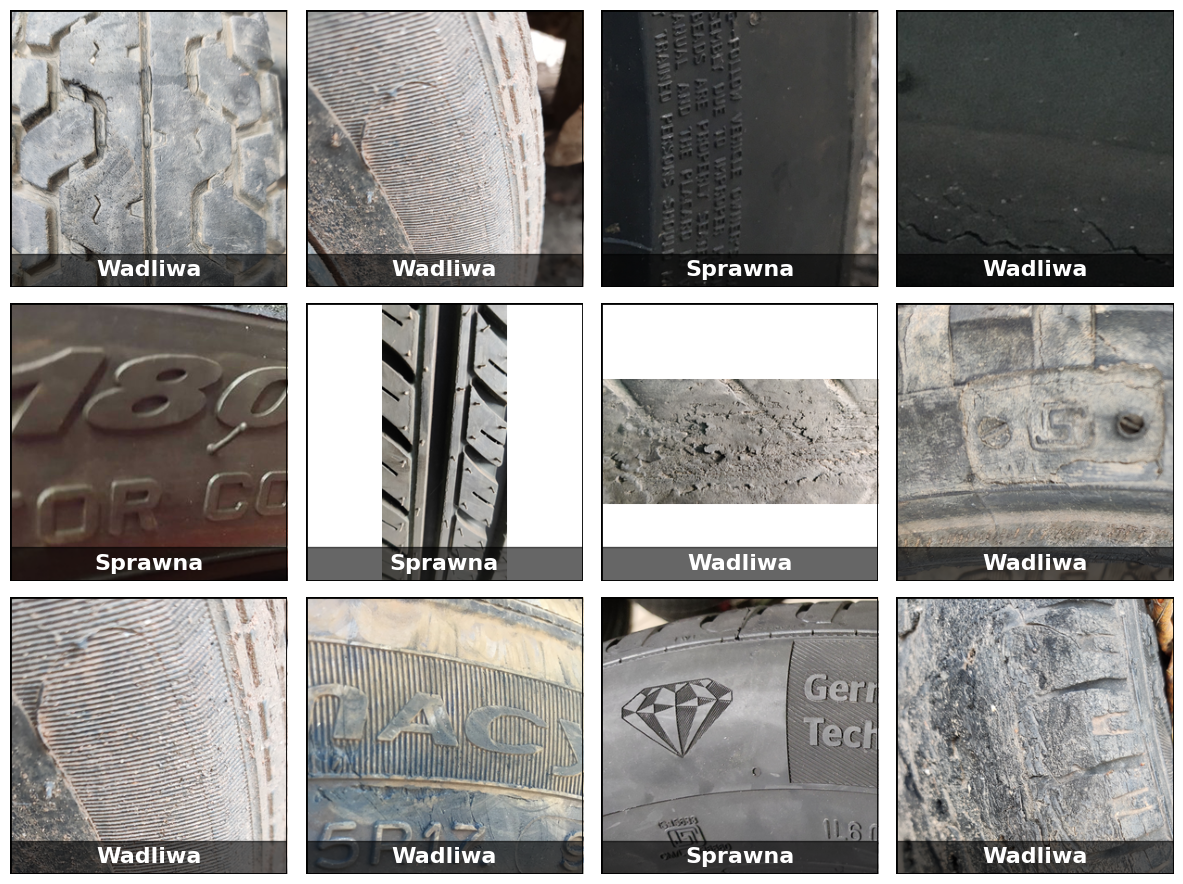

In [ ]:
display_random_images(research_dataset_path)

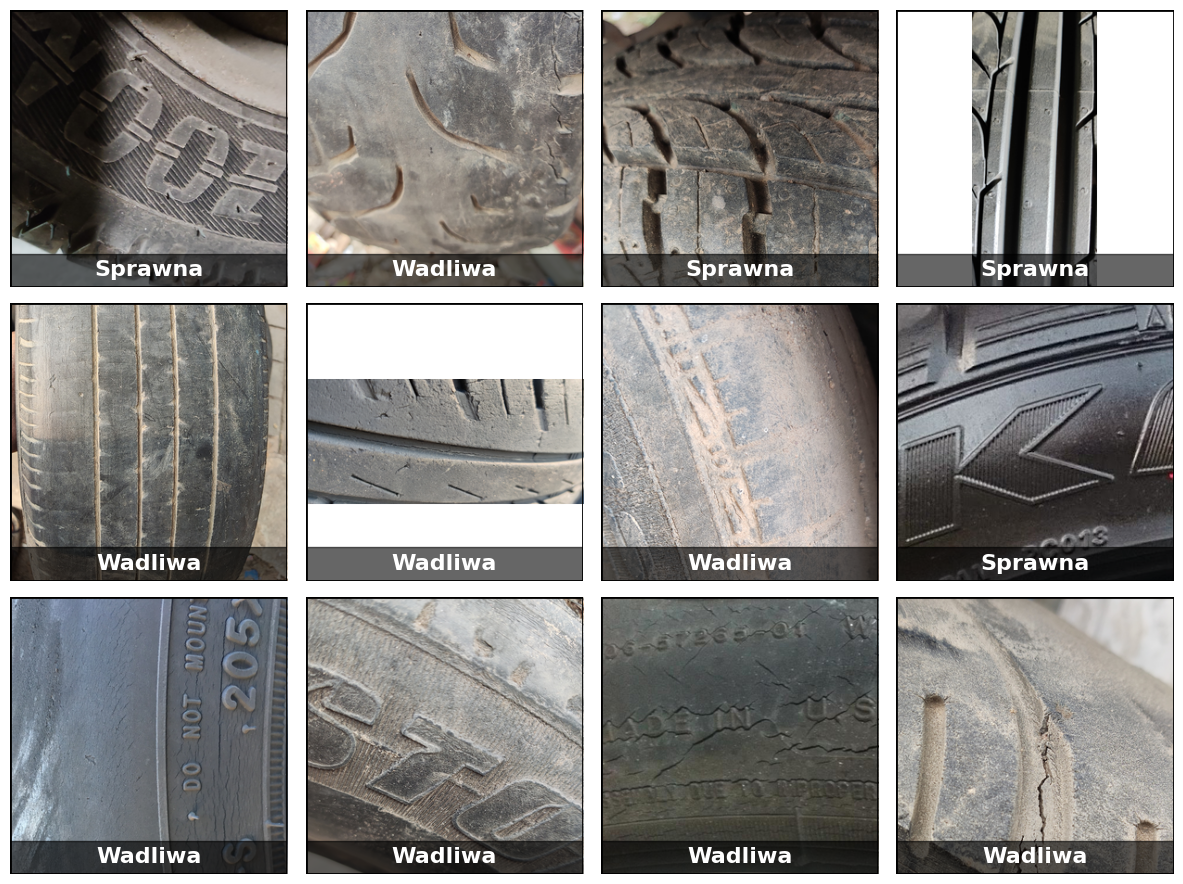

In [ ]:
display_random_images(research_dataset_path)

#### Wymiary zdjęć


In [ ]:
def get_image_dimensions(path, categories=['good', 'defective']):
    dimensions = {'good': [], 'defective': []}

    for category in categories:
        category_path = os.path.join(path, category)
        images = os.listdir(category_path)

        for image_name in images:
            image_path = os.path.join(category_path, image_name)
            try:
                with Image.open(image_path) as img:
                    width, height = img.size
                    dimensions[category].append((width, height))
            except Exception as e:
                print(f"Error processing image {image_path}: {e}")

    return dimensions


In [ ]:
def plot_tire_image_dimensions(dimensions):
    """Plots the width and height of tire images (good as 'Sprawnych', defective as 'Wadliwych')."""

    for category, dims in dimensions.items():
        if dims:
            # Separate widths and heights from dimensions
            widths, heights = zip(*dims)
            plt.figure(figsize=(10, 6))

            # Use 'x' as the marker and increase transparency
            plt.scatter(widths, heights, label=f'{category.capitalize()}', alpha=0.8, marker='x', s=50, color='blue')

            # Title with Polish names for categories and pixel unit
            if category == 'good':
                plt.title('Wymiary zdjęć opon sprawnych w pikselach')
            else:
                plt.title('Wymiary zdjęć opon wadliwych w pikselach')

            # Label axes
            plt.xlabel('Szerokość (Width)')
            plt.ylabel('Wysokość (Height)')

            # More visible grid with dashed lines
            plt.grid(True, linestyle='--', alpha=0.6)

            # Show legend and plot
            plt.legend()
            plt.show()
        else:
            print(f"No data available for category: {category}")


In [ ]:
dimensions = get_image_dimensions(research_dataset_path)

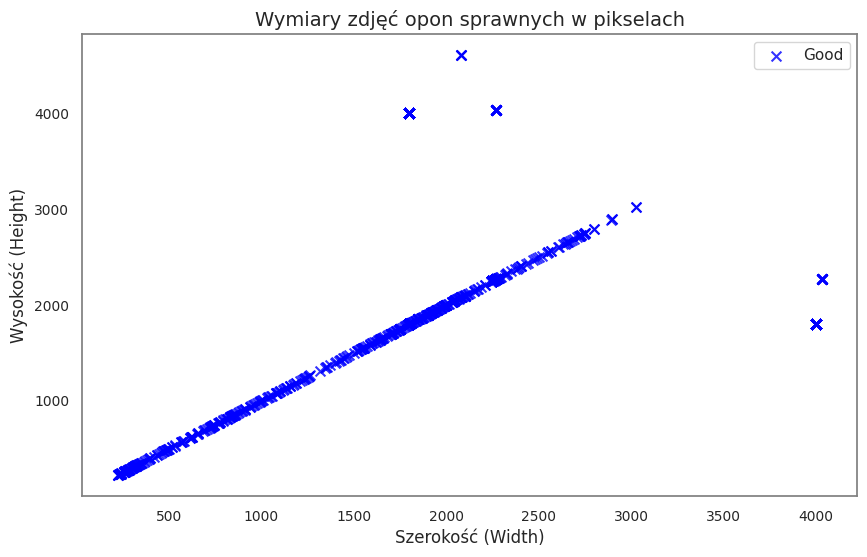

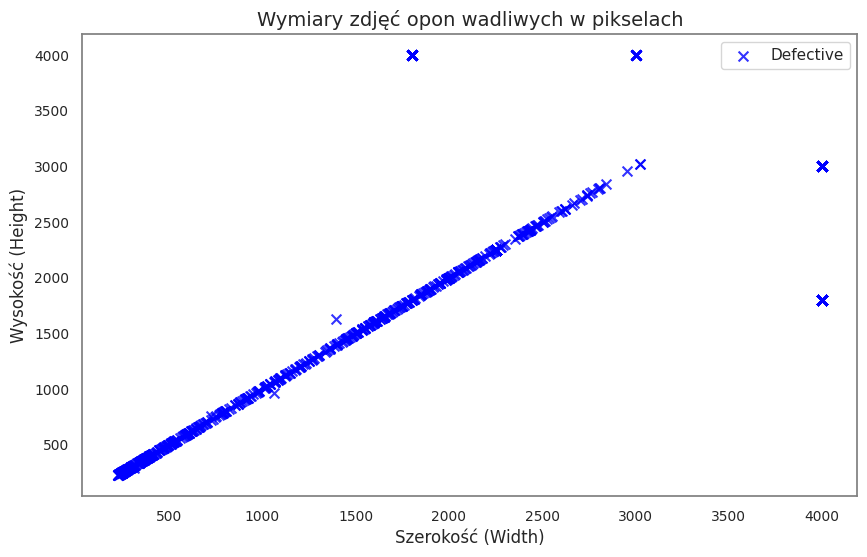

In [ ]:
plot_tire_image_dimensions(dimensions)

In [ ]:
def plot_boxplot_image_dimensions(dimensions):
    """Plots box plots for width and height of tire images for good and defective categories with custom styling."""

    for category, dims in dimensions.items():
        if dims:
            # Separate widths and heights
            widths, heights = zip(*dims)
            plt.figure(figsize=(10, 6))

            # Create box plot for width and height
            plt.boxplot([widths, heights], labels=['Szerokość (Width)', 'Wysokość (Height)'], patch_artist=True,
                        boxprops=dict(facecolor='lightblue', color='blue'),  # Color styling for the box
                        medianprops=dict(color='red'),  # Color for the median line
                        whiskerprops=dict(color='blue'),  # Color for whiskers
                        capprops=dict(color='blue'),  # Color for caps
                        flierprops=dict(marker='o', color='red', markersize=8, alpha=0.5))  # Outliers styling

            # Title with Polish names for categories
            if category == 'good':
                plt.title('Rozkład szerokości i wysokości zdjęć opon sprawnych w pikselach')
            else:
                plt.title('Rozkład szerokości i wysokości zdjęć opon wadliwych w pikselach')

            # Labels for the axes
            plt.xlabel('Rodzaj wymiaru')
            plt.ylabel('Wymiary w pikselach')

            # Add a more visible grid
            plt.grid(True, linestyle='--', alpha=0.6)

            # Show plot
            plt.show()
        else:
            print(f"No data available for category: {category}")


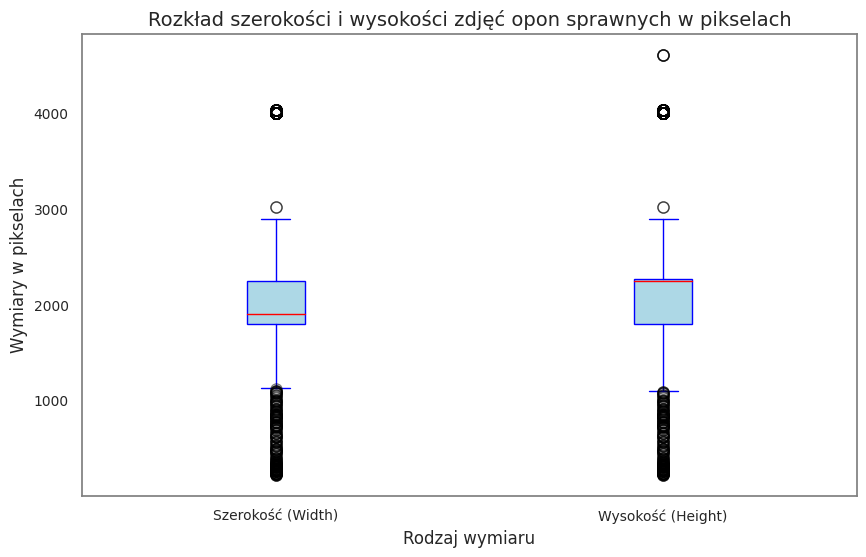

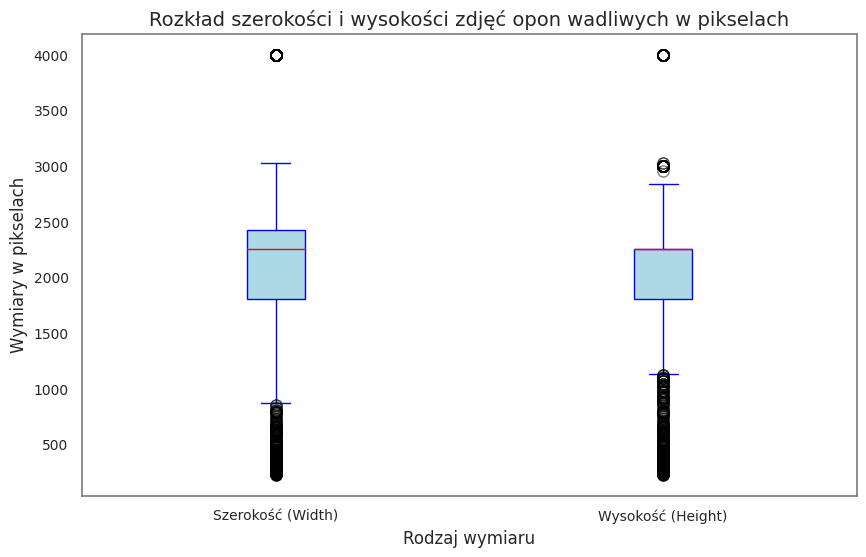

In [ ]:
plot_boxplot_image_dimensions(dimensions)

Wnioski:
* Podobieństwa w rozkładach: Mediany oraz zakresy dla szerokości i wysokości obrazów opon sprawnych i wadliwych są zbliżone
* Brak istotnych różnic w wymiarach obrazów między klasami

#### Rozkład kolorów w obrazach

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_color_distribution_by_category(dataset_path, categories=['good', 'defective']):
    """Plots the average color distribution for 'good' and 'defective' images in separate plots."""

    for category in categories:
        hist_r = np.zeros((256,))
        hist_g = np.zeros((256,))
        hist_b = np.zeros((256,))
        total_images = 0

        category_path = os.path.join(dataset_path, category)
        if not os.path.exists(category_path):
            print(f"Directory not found: {category_path}")
            continue

        # List all image files in the category folder
        image_files = [f for f in os.listdir(category_path) if f.endswith(('.jpg', '.png'))]

        # Process each image
        for image_file in image_files:
            image_path = os.path.join(category_path, image_file)
            image = cv2.imread(image_path)

            if image is None:
                print(f"Error loading image: {image_file}")
                continue

            channels = cv2.split(image)  # Split into R, G, B channels

            # Accumulate the histograms for each channel
            hist_b += cv2.calcHist([channels[0]], [0], None, [256], [0, 256]).flatten()
            hist_g += cv2.calcHist([channels[1]], [0], None, [256], [0, 256]).flatten()
            hist_r += cv2.calcHist([channels[2]], [0], None, [256], [0, 256]).flatten()

            total_images += 1

        # Check if any images were processed
        if total_images == 0:
            print(f"No images found in {category_path}")
            continue

        # Normalize the histograms by the number of images
        hist_r /= total_images
        hist_g /= total_images
        hist_b /= total_images

        # Plot the histograms for R, G, B channels for the current category
        plt.figure(figsize=(12, 6))
        plt.plot(hist_b, color='blue', label='Blue')
        plt.plot(hist_g, color='green', label='Green')
        plt.plot(hist_r, color='red', label='Red')

        # Add title based on the category
        if category == 'good':
            plt.title('Średni rozkład kolorów w obrazach opon sprawnych (RGB)')
        else:
            plt.title('Średni rozkład kolorów w obrazach opon wadliwych (RGB)')

        # Labels and legend
        plt.xlabel('Wartość koloru (Color Value)')
        plt.ylabel('Średnia liczba pikseli (Average Pixel Count)')
        plt.legend(loc='upper right')
        plt.grid(True, linestyle='--', alpha=0.6)

        # Show the plot for the current category
        plt.show()


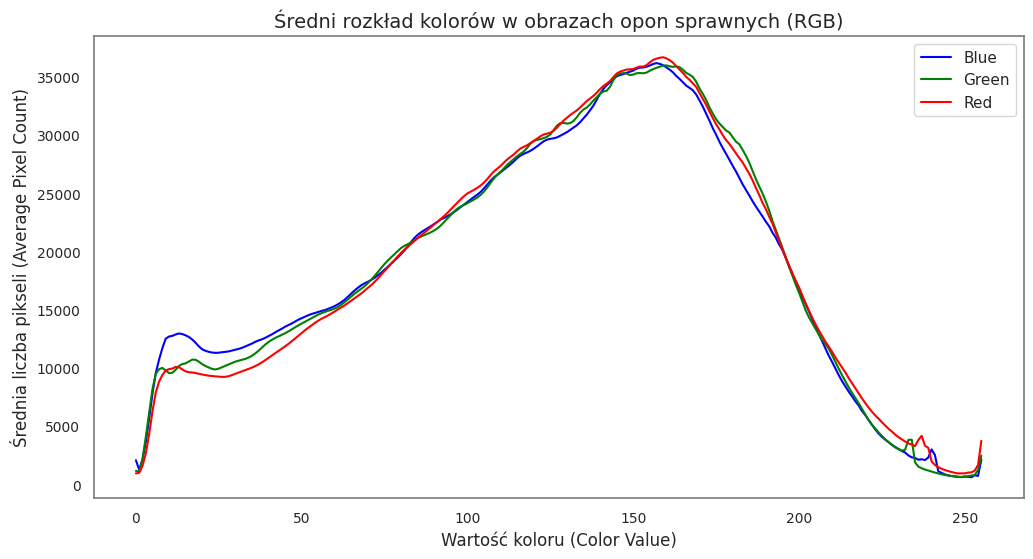

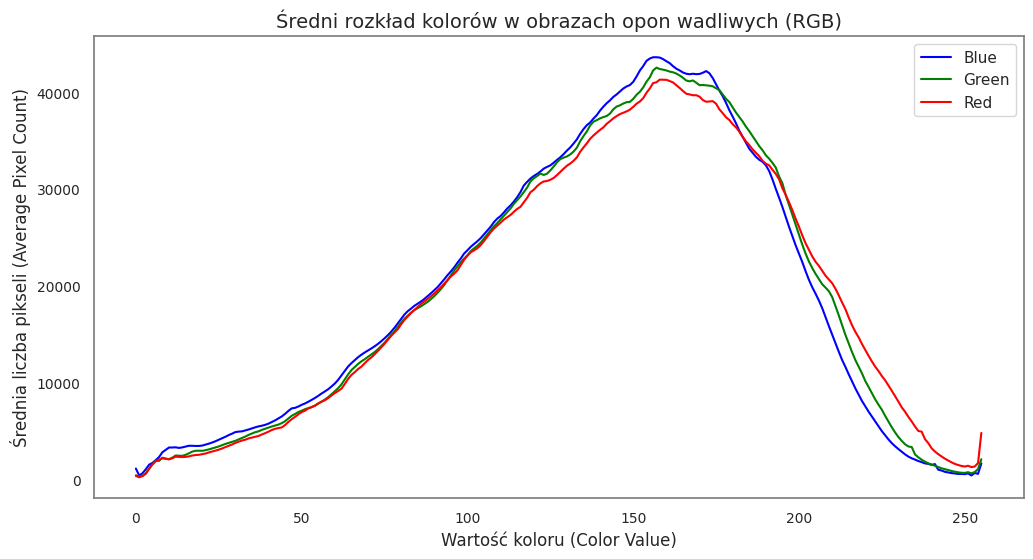

In [ ]:
plot_color_distribution_by_category(research_dataset_path)

Wnioski:
* Większość pikseli ma wartości w średnim zakresie (od 50 do 200), co wskazuje na ogólnie ciemne tło i oświetlenie.
* Brak znacznych różnic między kanałami RGB: Rozkład kanałów RGB jest bardzo podobny, co sugeruje, że zdjęcia są praktycznie monochromatyczne. Może to wynikać z charakteru zdjęć opon, które są w dominujących odcieniach szarości i czerni.
* Brak jaskrawych kolorów:

## Wstepne przygotowanie danych

In [7]:
import os
from PIL import Image
import numpy as np
import shutil

In [8]:
# Path to the research dataset folder
research_dataset_path = '/content/drive/My Drive/Magisterka/ResearchData'
processed_dataset_path = '/content/drive/My Drive/Magisterka/ProcessedData'

### Weryfikacja poprawnosci danych

In [9]:
def verify_image_file(image_path):
    """
    Verifies if an image file is valid and not corrupted.
    Returns True if the image is valid, False otherwise.
    """
    try:
        with Image.open(image_path) as img:
            img.verify()  # Verify if image is not corrupted
        return True
    except (IOError, SyntaxError) as e:
        print(f"Corrupted image found: {image_path}. Error: {e}")
        return False


In [10]:
def clean_corrupted_files(corrupted_files):
    """
    Deletes corrupted image files from the dataset.
    """
    for file_path in corrupted_files:
        try:
            os.remove(file_path)
            print(f"Deleted corrupted file: {file_path}")
        except Exception as e:
            print(f"Error deleting file {file_path}: {e}")

### Zmiana rozmiaru zdjęć


In [11]:
def resize_image(image, target_size=(224, 224)):
    """
    Resizes the image to the target size.
    """
    # Resize the image
    img_resized = image.resize(target_size)
    return img_resized


In [12]:
def save_image(image, save_path, image_name):
    """
    Saves  image to the specified save path.
    Ensures that the full directory structure exists.
    """
    try:
        # Ensure that the directory exists (create the full path if necessary)
        os.makedirs(save_path, exist_ok=True)  # Create directories recursively if they don't exist

        # Save the image in the specified path
        image.save(os.path.join(save_path, image_name))  # Save the image
    except Exception as e:
        print(f"Error saving image {image_name} to {save_path}: {e}")

In [13]:
def resize_and_save_images_in_folder(folder_path, target_folder, target_size=(224, 224)):
    """
    Resizes images and saves them to a new folder structure.
    Also returns stats on how many images were processed and how many were corrupted.
    """
    corrupted_files = []
    processed_count = 0  # Counter for successfully processed images

    for category in ['good', 'defective']:
        category_path = os.path.join(folder_path, category)
        save_category_path = os.path.join(target_folder, category)  # Path to save resized images
        image_files = os.listdir(category_path)

        for image_name in image_files:
            image_path = os.path.join(category_path, image_name)

            # Verify if the image is valid
            if verify_image_file(image_path):
                try:
                    # Open the image
                    with Image.open(image_path) as img:
                        # Resize the image
                        resized_image = resize_image(img, target_size)

                        # Save the resized image to the new folder
                        save_image(resized_image, save_category_path, image_name)
                        processed_count += 1  # Increment counter for successful processing
                except Exception as e:
                    print(f"Error processing image {image_path}: {e}")
            else:
                # Add corrupted files to the list for later handling
                corrupted_files.append(image_path)

    return processed_count, len(corrupted_files)  # Return counts of processed and corrupted files

In [25]:
# Resize the images and save to the new folder structure
processed_count, corrupted_count = resize_and_save_images_in_folder(research_dataset_path, processed_dataset_path, target_size=(224, 224))

# Print the results
print(f"Number of images successfully processed and saved: {processed_count}")
print(f"Number of corrupted images: {corrupted_count}")

Number of images successfully processed and saved: 3518
Number of corrupted images: 0


### Normalizacja

In [14]:
def normalize_image(image):
    """
    Normalizes the pixel values of an image to the range [0, 1].
    """
    # Convert image to NumPy array
    img_array = np.array(image)

    # Normalize pixel values to the range [0, 1]
    img_normalized = img_array / 255.0

    return img_normalized


In [15]:
def load_and_normalize_data(processed_data_path):
    """
    Loads images from the processed dataset, normalizes them, and returns the data with labels.
    All images are converted to RGB format (3 channels) to ensure consistency.
    """
    data = []
    labels = []

    for category, label in [('good', 0), ('defective', 1)]:
        category_path = os.path.join(processed_data_path, category)
        image_files = os.listdir(category_path)

        for image_name in image_files:
            image_path = os.path.join(category_path, image_name)

            try:
                with Image.open(image_path) as img:
                    # Convert to RGB to ensure consistency in channels (3 channels)
                    img_rgb = img.convert('RGB')

                    # Normalize the image
                    img_normalized = normalize_image(img_rgb)

                    # Append the normalized image and corresponding label
                    data.append(img_normalized)
                    labels.append(label)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")

    # Convert lists to NumPy arrays for further processing
    data = np.array(data)
    labels = np.array(labels)

    return data, labels


### Podział zbioru na treningowy, walidacyjny i testowy

In [2]:
from sklearn.model_selection import train_test_split

def split_dataset(data, labels, test_size=0.15, val_size=0.15):
    """
    Splits the dataset into training, validation, and test sets.

    Parameters:
    - data: array-like, input data (images).
    - labels: array-like, labels corresponding to the data.
    - test_size: proportion of the dataset to include in the test set (default is 15%).
    - val_size: proportion of the training set to include in the validation set (default is 15%).

    Returns:
    - X_train, X_val, X_test: input data split into training, validation, and test sets.
    - y_train, y_val, y_test: corresponding labels for each split.
    """
    # First split: training+validation vs. test set
    X_train_val, X_test, y_train_val, y_test = train_test_split(data, labels, test_size=test_size, random_state=42)

    # Second split: training vs. validation set (from the remaining data)
    val_relative_size = val_size / (1 - test_size)  # Adjust validation size relative to remaining data
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_relative_size, random_state=42)

    return X_train, X_val, X_test, y_train, y_val, y_test

## Ładowanie danych

In [17]:
# Load and normalize the data
data, labels = load_and_normalize_data(processed_dataset_path)

# Print the shape of the data and labels for verification
print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")

Data shape: (3518, 224, 224, 3)
Labels shape: (3518,)


In [3]:
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(data, labels, test_size=0.2, val_size=0.2)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

NameError: name 'data' is not defined

## Inne